# **Project Overview**

This notebook focuses on customer segmentation using unsupervised learning techniques.
The goal is to identify customer groups based on their transactional behavior to optimize coupon distribution strategies.


## **Data Loading & Preprocessing**

In [189]:
# Load Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

In [190]:
# Load the Excel file # change the path as needed
file_path = "/content/data/E-commerce_data.xlsx"

# Read all sheets into a dictionary of DataFrames
xls = pd.ExcelFile(file_path)

# Load each sheet into a DataFrame
customers_df = pd.read_excel(xls, sheet_name="customers")
genders_df = pd.read_excel(xls, sheet_name="genders")
cities_df = pd.read_excel(xls, sheet_name="cities")
transactions_df = pd.read_excel(xls, sheet_name="transactions")
branches_df = pd.read_excel(xls, sheet_name="branches")
merchants_df = pd.read_excel(xls, sheet_name="merchants")

# Display first few rows of each table
print("Customers Table:")
customers_df.head()


Customers Table:


,customer_id,join_date,city_id,gender_id
0,1,2022-01-08,7,1
1,2,2023-05-02,20,2
2,3,2023-05-14,15,1
3,4,2022-11-25,11,2
4,5,2023-04-26,8,1


In [191]:
print("\nGenders Table:")
genders_df.head()


Genders Table:


,gender_id,gender_name
0,1,Male
1,2,Female


In [192]:
print("\nCities Table:")
cities_df.head()




Cities Table:


,city_id,city_name
0,1,Cairo
1,2,Alexandria
2,3,Giza
3,4,Shubra El-Kheima
4,5,Port Said


In [193]:
print("\nTransactions Table:")
transactions_df.head()




Transactions Table:


,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6


In [194]:
print("\nBranches Table:")
branches_df.head()




Branches Table:


,branch_id,merchant_id
0,1,11
1,2,18
2,3,8
3,4,15
4,5,9


In [195]:
print("\nMerchants Table:")
merchants_df.head()


Merchants Table:


,merchant_id,merchant_name
0,1,Rivas Group
1,2,Peters-Acosta
2,3,"Duran, Perry and Stout"
3,4,Morton Ltd
4,5,Curtis-Fields


## **Merging all tables(sheets)**

In [196]:
# 1️ Merge Customers with Genders Table
customers_df = customers_df.merge(genders_df, on="gender_id", how="left")

# 2️ Merge Customers with Cities Table
customers_df = customers_df.merge(cities_df, on="city_id", how="left")

# 3️ Merge Transactions with Customers Table
merged_df = transactions_df.merge(customers_df, on="customer_id", how="left")

# 4️ Merge Transactions with Branches Table
merged_df = merged_df.merge(branches_df, on="branch_id", how="left")

# 5️ Merge Transactions with Merchants Table
merged_df = merged_df.merge(merchants_df, on="merchant_id", how="left")


In [197]:
# Display the final merged dataset
print("Merged DataFrame Sample:")

merged_df.head()

Merged DataFrame Sample:


,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,join_date,city_id,gender_id,gender_name,city_name,merchant_id,merchant_name
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7,2023-05-16,15,2,Female,Aswan,7,Berry-Anderson
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,2022-10-10,14,2,Female,Damietta,9,"Campbell, Shaffer and Martinez"
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7,2022-05-30,2,1,Male,Alexandria,7,Berry-Anderson
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2,2023-11-27,15,2,Female,Aswan,18,Lewis LLC
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,2021-09-04,14,1,Male,Damietta,15,Butler-Gomez


In [198]:
# Statistical information
merged_df.describe()

,transaction_id,customer_id,transaction_date,burn_date,branch_id,join_date,city_id,gender_id,merchant_id
count,5000.000000,5000.000000,5000,2516,5000.000000,5000,5000.000000,5000.00000,5000.000000
mean,2500.500000,509.551600,2023-10-22 04:38:47.040000,2023-12-01 20:39:06.581876224,5.529800,2023-01-18 14:41:34.080000,10.091800,1.48660,12.882600
min,1.000000,1.000000,2021-08-05 00:00:00,2021-08-14 00:00:00,1.000000,2021-07-18 00:00:00,1.000000,1.00000,7.000000
25%,1250.750000,262.000000,2023-05-31 18:00:00,2023-07-12 00:00:00,3.000000,2022-04-10 00:00:00,5.000000,1.00000,9.000000
50%,2500.500000,514.000000,2024-01-02 00:00:00,2024-02-11 00:00:00,6.000000,2023-01-11 00:00:00,10.000000,1.00000,13.000000
75%,3750.250000,758.000000,2024-05-08 00:00:00,2024-06-18 00:00:00,8.000000,2023-10-25 00:00:00,15.000000,2.00000,15.000000
max,5000.000000,1000.000000,2024-07-14 00:00:00,2024-10-08 00:00:00,10.000000,2024-07-13 00:00:00,20.000000,2.00000,20.000000
std,1443.520003,287.065172,NaN,NaN,2.895788,NaN,5.860703,0.49987,4.000452


In [199]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      5000 non-null   int64         
 1   customer_id         5000 non-null   int64         
 2   transaction_date    5000 non-null   datetime64[ns]
 3   transaction_status  5000 non-null   object        
 4   coupon_name         5000 non-null   object        
 5   burn_date           2516 non-null   datetime64[ns]
 6   branch_id           5000 non-null   int64         
 7   join_date           5000 non-null   datetime64[ns]
 8   city_id             5000 non-null   int64         
 9   gender_id           5000 non-null   int64         
 10  gender_name         5000 non-null   object        
 11  city_name           5000 non-null   object        
 12  merchant_id         5000 non-null   int64         
 13  merchant_name       5000 non-null   object      

## **Check for duplicate rows**

In [200]:
# Check for duplicate rows
duplicate_rows = merged_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


## **Removing Unnecessary Columns, Feature engineering, handling missing valuse, encoding categorical colomns if needed**

## Removing Unnecessary Columns

In this step, we remove columns that are not useful for clustering to simplify our dataset.

transaction_id → Unique identifier, no impact on clustering.

coupon_name → Each value is unique (5000 different values), so it does not provide meaningful patterns for clustering.

merchant_name → Already represented by merchant_id.

gender_name → Already represented by gender_id.

city_name → Already represented by city_id.

In [201]:
# Count the number of unique coupon names, if is just unique name and doesn't contribute in clustring customers we will dorp it
num_unique_coupons = merged_df['coupon_name'].nunique()
print(f"Number of unique coupon names: {num_unique_coupons}")

# Drop unnecessary columns
columns_to_drop = ['transaction_id', 'coupon_name', 'merchant_name', 'gender_name', 'city_name']

merged_df.drop(columns=columns_to_drop, inplace=True)

merged_df.head()

Number of unique coupon names: 5000


,customer_id,transaction_date,transaction_status,burn_date,branch_id,join_date,city_id,gender_id,merchant_id
0,733,2024-05-11,subscribed,NaT,7,2023-05-16,15,2,7
1,631,2023-05-15,burned,2023-06-04,5,2022-10-10,14,2,9
2,309,2022-11-13,subscribed,NaT,7,2022-05-30,2,1,7
3,695,2024-01-26,subscribed,NaT,2,2023-11-27,15,2,18
4,288,2022-10-12,burned,2022-11-20,6,2021-09-04,14,1,15


## s**onverting trasaciton based table (merged_df) into customer based table (customers_cluster_df)**
Our current dataset **`merged_df` is transaction-based**, meaning **each row represents a single transaction**, not a customer. This structure is not ideal for our goal, which is **customer segmentation**.  

---


1- **Customers Appear Multiple Times**  
   - Since each row represents a transaction, customers **are duplicated** in the dataset.  
   - Clustering on this data would **group transactions, not customers**, leading to incorrect segmentation.  

2- **We Need Customer-Level Insights**  
   - Our goal is to **group customers based on their behavior**, such as coupon usage, loyalty, and preferences.  
   - This requires **aggregating** their transactions into **one row per customer**.  

3- **Transaction-Level Data is Too Granular**  
   - Features like `transaction_date` or `burn_date` change for every transaction.  
   - Instead of individual transactions, we need **summary statistics** for each customer, such as:  
     - **Total transactions & burned coupons**  
     - **Most frequent coupon usage month/day**  
     - **Preferred merchant & branch**  

---

### **How Will We Convert `merged_df` into a Customer-Based Table?**  
1- **Group by `customer_id`** → Ensure each row represents one customer.  
2- **Aggregate key transactional metrics** → Count total transactions, burned transactions, and unique branches/merchants used.  
3- **Extract meaningful features** → Find the most common month/day of transactions and preferred branches/merchants.  

---

### **Expected Outcome: `customers_cluster_df`**
| **Customer-Based Feature** | **Extracted From** | **Why?** |
|----------------|----------------------|----------------------|
| `total_transactions` | `transaction_status` | Measures customer activity. |
| `total_burned` | `burn_date` | Shows coupon usage engagement. |
| `total_subscribed` | `total_transactions - total_burned` | Identifies customers who claim but don’t redeem coupons. |
| `never_burned` | `total_burned == 0` | Explicitly marks customers who never burned a coupon.|
| `burned_ratio` | `total_burned / total_transactions` | Captures engagement with coupons in a single value.|
| `customer_tenure_days` | `join_date` | Indicates how long a customer has been active. |
| `days_since_last_burn` | `burn_date` | Shows recency of engagement. |
| `preferred_transaction_month` | `transaction_date` | Identifies seasonal trends. |
| `preferred_transaction_day_of_week` | `transaction_date` | Helps detect weekly patterns. |
| `preferred_burn_month` | `burn_date` | Reveals when coupons are most used. |
| `preferred_burn_day_of_week` | `burn_date` | Highlights preferred coupon burn days. |
| `preferred_branch_id` | `branch_id` | Identifies the most used branch. |
| `preferred_merchant_id` | `merchant_id` | Identifies the most frequently used merchant. |

**After this transformation, we will have a clean customer-based dataset (`customers_cluster_df`) ready for clustering!**

In [202]:
import pandas as pd
from datetime import datetime

# Ensure datetime columns are in correct format
merged_df['transaction_date'] = pd.to_datetime(merged_df['transaction_date'], errors='coerce')
merged_df['burn_date'] = pd.to_datetime(merged_df['burn_date'], errors='coerce')
merged_df['join_date'] = pd.to_datetime(merged_df['join_date'], errors='coerce')

# Get today's date for calculations
today = datetime.today()

# 1️ **Convert datetime columns into numerical features**
# Compute customer tenure (days since joining)
merged_df['customer_tenure_days'] = (today - merged_df['join_date']).dt.days

# Extract preferred transaction month & day of the week
merged_df['preferred_transaction_month'] = merged_df['transaction_date'].dt.month
merged_df['preferred_transaction_day_of_week'] = merged_df['transaction_date'].dt.weekday

# Extract preferred burn month & day of the week (handling NaN values)
merged_df['preferred_burn_month'] = merged_df['burn_date'].dt.month.fillna(-1).astype(int)
merged_df['preferred_burn_day_of_week'] = merged_df['burn_date'].dt.weekday.fillna(-1).astype(int)

# Compute days since last burn (handling NaN values)
merged_df['days_since_last_burn'] = (today - merged_df['burn_date']).dt.days
# Find the maximum real `days_since_last_burn` (ignoring NaNs)
max_real_days_since_burn = merged_df['days_since_last_burn'].dropna().max()
merged_df['days_since_last_burn'] = merged_df['days_since_last_burn'].fillna(max_real_days_since_burn + 1).astype(int)


In [203]:
# Aggregate transaction data at the customer level
customers_cluster_df = merged_df.groupby('customer_id').agg({
    'gender_id': 'first',  # Keep gender as is
    'city_id': 'first',  # Keep city as is
    'customer_tenure_days': 'first',  # Already computed above
    'transaction_status': 'count',  # Total transactions per customer
    'burn_date': 'count',  # Total burned transactions per customer
    'days_since_last_burn': 'min',  # Most recent burn activity
    'preferred_transaction_month': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],  # Most common transaction month
    'preferred_transaction_day_of_week': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],  # Most common transaction day
    'branch_id': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],  # Most common branch id per customer
    'merchant_id': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],  #  Most common merchang id per customer
}).reset_index()


# Filter only burned transactions before computing mode
burned_transactions = merged_df[merged_df['transaction_status'] == "burned"]

# Compute the most common burn month & day correctly
customers_burn_info = burned_transactions.groupby('customer_id').agg({
    'preferred_burn_month': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],
    'preferred_burn_day_of_week': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
}).reset_index()

# Merge the corrected burn month & day into customers_cluster_df
customers_cluster_df = customers_cluster_df.merge(customers_burn_info, on='customer_id', how='left')
customers_cluster_df['preferred_burn_month'] = customers_cluster_df['preferred_burn_month'].fillna(-1).astype(int)
customers_cluster_df['preferred_burn_day_of_week'] = customers_cluster_df['preferred_burn_day_of_week'].fillna(-1).astype(int)


# Rename Columns for Clarity
customers_cluster_df.rename(columns={
    'transaction_status': 'total_transactions',
    'burn_date': 'total_burned',
    'branch_id': 'preferred_branch_id',
    'merchant_id': 'preferred_merchant_id',
}, inplace=True)

# Add total_subscribed column (claimed but not burned)
customers_cluster_df['total_subscribed'] = customers_cluster_df['total_transactions'] - customers_cluster_df['total_burned']

# Add `never_burned` column (1 if total_burned == 0, else 0)
customers_cluster_df['never_burned'] = (customers_cluster_df['total_burned'] == 0).astype(int)

# Add `burned_ratio` as a new feature
customers_cluster_df['burned_ratio'] = customers_cluster_df['total_burned'] / customers_cluster_df['total_transactions']


# Reorder columns in a logical sequence
desired_column_order = [
    'customer_id', 'gender_id', 'city_id', 'customer_tenure_days',
    'total_transactions', 'total_burned', 'total_subscribed','never_burned','burned_ratio', 'days_since_last_burn',
    'preferred_transaction_month', 'preferred_transaction_day_of_week',
    'preferred_burn_month', 'preferred_burn_day_of_week',
    'preferred_branch_id', 'preferred_merchant_id'
]

# Apply the column order
customers_cluster_df = customers_cluster_df[desired_column_order]
customers_cluster_df.head()

,customer_id,gender_id,city_id,customer_tenure_days,total_transactions,total_burned,total_subscribed,never_burned,burned_ratio,days_since_last_burn,preferred_transaction_month,preferred_transaction_day_of_week,preferred_burn_month,preferred_burn_day_of_week,preferred_branch_id,preferred_merchant_id
0,1,1,7,1145,7,3,4,0,0.428571,844,7,0,7,1,8,15
1,2,2,20,666,3,1,2,0,0.333333,643,5,4,5,3,3,8
2,3,1,15,654,5,1,4,0,0.200000,446,6,3,12,4,2,18
3,4,2,11,824,1,0,1,1,0.000000,1293,1,6,-1,-1,10,13
4,5,1,8,672,4,3,1,0,0.750000,218,7,1,7,1,5,13


### **Now we have clean and customer-based dataset (customers_cluster_df) which is ready for clustering**

## Checking Outliers

In [204]:
import numpy as np

# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = np.percentile(data[column], 25)  # First quartile (25th percentile)
    Q3 = np.percentile(data[column], 75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range

    lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


# Select all numerical columns for outlier detection
numerical_columns = [
    'customer_tenure_days', 'total_transactions', 'total_burned', 'total_subscribed', 'burned_ratio',
    'days_since_last_burn', 'preferred_transaction_month', 'preferred_transaction_day_of_week',
    'preferred_burn_month', 'preferred_burn_day_of_week', 'preferred_branch_id', 'preferred_merchant_id'
]

# Detect outliers using IQR method for all numerical columns
outlier_results_all = {}
for column in numerical_columns:
    outliers, lower, upper = detect_outliers_iqr(customers_cluster_df, column)
    outlier_results_all[column] = {
        "num_outliers": len(outliers),
        "lower_bound": lower,
        "upper_bound": upper
    }

# Convert results to DataFrame for better visualization
outlier_summary_all_df = pd.DataFrame.from_dict(outlier_results_all, orient='index')


outlier_summary_all_df

,num_outliers,lower_bound,upper_bound
customer_tenure_days,0,-356.000000,1900.000000
total_transactions,13,-1.500000,10.500000
total_burned,0,-3.500000,8.500000
total_subscribed,19,-2.000000,6.000000
burned_ratio,0,-0.166667,1.166667
days_since_last_burn,102,-205.000000,915.000000
preferred_transaction_month,0,-4.000000,12.000000
preferred_transaction_day_of_week,0,-6.000000,10.000000
preferred_burn_month,0,-5.500000,14.500000
preferred_burn_day_of_week,0,-4.500000,7.500000


## handling outlires:

we will keep oultiers of colomns total_transactions and total_subscribed since all values are valid business cases (e.g., VIP customers).

handle outliers of colomn days_since_last_burn with log


In [205]:
# Apply Log Transformation for `days_since_last_burn`
customers_cluster_df['days_since_last_burn_log'] = np.log1p(customers_cluster_df['days_since_last_burn'])

# Drop the original column
customers_cluster_df.drop(columns=['days_since_last_burn'], inplace=True)

## Scaling
we need to scale valus since the lower bound and upper bound are different for differnt colomns

In [206]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns for scaling
scaling_columns = [
    'customer_tenure_days', 'total_transactions', 'total_burned', 'total_subscribed', 'burned_ratio',
    'days_since_last_burn_log', 'preferred_transaction_month', 'preferred_transaction_day_of_week',
    'preferred_burn_month', 'preferred_burn_day_of_week', 'preferred_branch_id', 'preferred_merchant_id'
]

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling
customers_cluster_df[scaling_columns] = scaler.fit_transform(customers_cluster_df[scaling_columns])

customers_cluster_df.head()


,customer_id,gender_id,city_id,customer_tenure_days,total_transactions,total_burned,total_subscribed,never_burned,burned_ratio,preferred_transaction_month,preferred_transaction_day_of_week,preferred_burn_month,preferred_burn_day_of_week,preferred_branch_id,preferred_merchant_id,days_since_last_burn_log
0,1,1,7,1.147272,0.855575,0.293019,0.926711,0,-0.298723,0.878921,-1.073115,0.812490,-0.458101,1.368775,0.986721,1.470401
1,2,2,20,-0.333803,-0.904516,-0.992105,-0.318557,0,-0.671066,0.181566,0.945545,0.174497,0.561161,-0.420911,-0.976230,1.021648
2,3,1,15,-0.370907,-0.024470,-0.992105,0.926711,0,-1.192347,0.530244,0.440880,2.407472,1.070792,-0.778848,1.827985,0.418428
3,4,2,11,0.154735,-1.784562,-1.634667,-0.941191,1,-1.974267,-1.213144,1.954875,-1.739482,-1.477364,2.084649,0.425878,2.174422
4,5,1,8,-0.315251,-0.464493,0.293019,-0.941191,0,0.957934,0.878921,-0.568450,0.812490,-0.458101,0.294963,0.425878,-0.760270


# **Feature Selection**

In [207]:
# Step 1: Feature Selection
selected_features = [
    'customer_tenure_days', 'total_transactions', 'total_burned', 'total_subscribed',
    'burned_ratio', 'days_since_last_burn_log', 'preferred_transaction_month',
    'preferred_transaction_day_of_week', 'preferred_burn_month', 'preferred_burn_day_of_week',
    'preferred_branch_id', 'preferred_merchant_id'
]

X = customers_cluster_df[selected_features]


# **Model development**

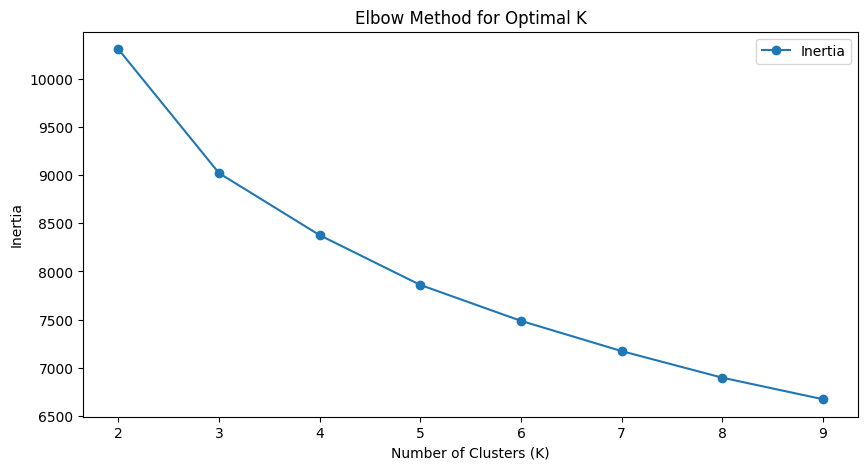

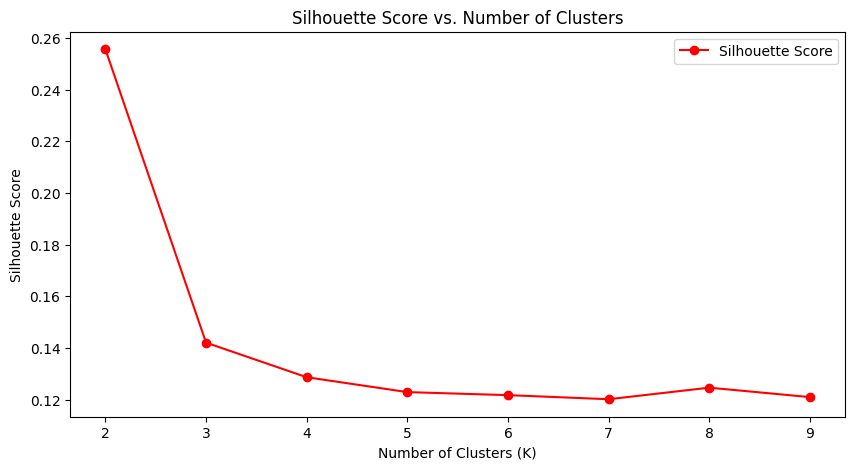

In [217]:
# Step 2: Finding Optimal Clusters (Elbow Method)
inertia_values = []
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', label="Inertia")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.legend()
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='r', label="Silhouette Score")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.legend()
plt.show()



### Key Findings from Clustering Outputs

1- Elbow Method (Optimal K Selection)

The Elbow Method graph shows a strong drop at K = 3, indicating that three clusters provide a good trade-off between compactness and separation.

Beyond K = 3, the inertia decrease slows down, making additional clusters less beneficial.

Conclusion:

K = 3 is the best choice based on the elbow method.

2- Silhouette Score Analysis

The Silhouette Score is highest at K = 2 (~0.26), meaning two clusters have the best separation.

As K increases beyond 2, the silhouette score drops significantly, meaning clusters become less distinct.

K = 2 gives the best separation but may be too broad for practical segmentation.

K = 3 is still a viable option but results in slightly lower silhouette scores (~0.14-0.15).


### Final thoughts

If the goal is best cluster separation, use K = 2 (highest Silhouette Score).

If the goal is meaningful segmentation, use K = 3 (supported by the Elbow Method and Dendrogram).

# **using k = 3**

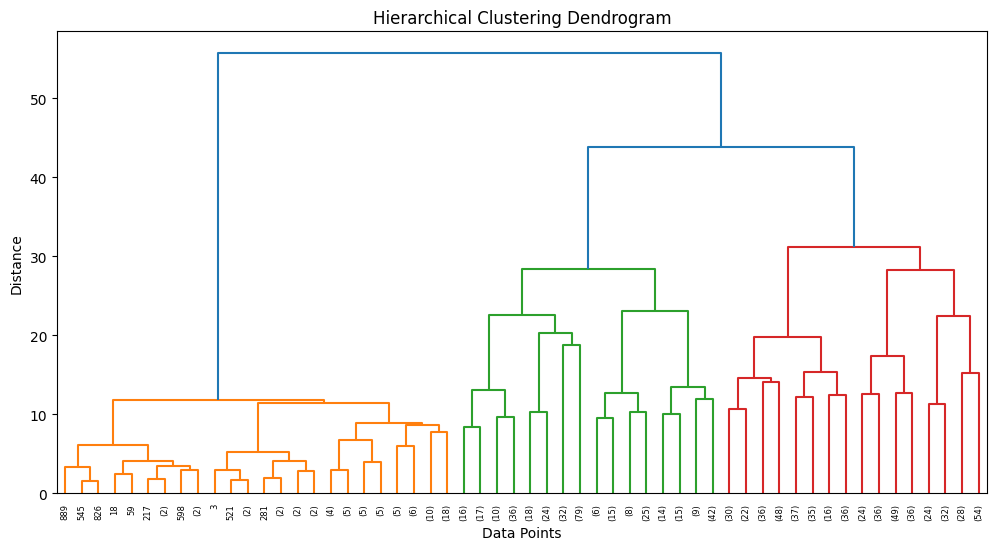

In [227]:
# Step 3: K-Means Clustering
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customers_cluster_df['kmeans_cluster'] = kmeans.fit_predict(X)

# Step 4: DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
customers_cluster_df['dbscan_cluster'] = dbscan.fit_predict(X)

# Step 5: Hierarchical Clustering (Dendrogram)
plt.figure(figsize=(12, 6))
linked = linkage(X, method='ward')
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

### Key Findings from Hierarchical Clustering Dendrogram (K = 3)

The dendrogram confirms three distinct clusters, supporting the decision to use K = 3.

The three main branches indicate clear separations in customer behavior.

Clusters on the left (orange) are more compact, while clusters on the right (red) show greater variation, suggesting different engagement levels.

Conclusion:

Three well-defined customer segments exist, making K = 3 a meaningful choice for analysis.

# **Model Evaluation**

In [229]:
# Step 6: Model Evaluation
kmeans_silhouette = silhouette_score(X, customers_cluster_df['kmeans_cluster'])
kmeans_db_index = davies_bouldin_score(X, customers_cluster_df['kmeans_cluster'])

dbscan_silhouette = silhouette_score(X, customers_cluster_df['dbscan_cluster']) if len(set(customers_cluster_df['dbscan_cluster'])) > 1 else -1
dbscan_db_index = davies_bouldin_score(X, customers_cluster_df['dbscan_cluster']) if len(set(customers_cluster_df['dbscan_cluster'])) > 1 else -1

# Display Clustering Model Evaluation Results
evaluation_results = pd.DataFrame({
    "Model": ["K-Means", "DBSCAN"],
    "Silhouette Score": [kmeans_silhouette, dbscan_silhouette],
    "Davies-Bouldin Index": [kmeans_db_index, dbscan_db_index]
})

print("\nClustering Model Evaluation Results:")
print(evaluation_results)



Clustering Model Evaluation Results:
     Model  Silhouette Score  Davies-Bouldin Index
0  K-Means          0.142067              2.081460
1   DBSCAN         -0.204846              1.918242


Key Findings from Model Evaluation (K = 3)
1- K-Means Performance

Silhouette Score: 0.1420 → Moderate cluster separation, meaning some overlap exists between clusters.

Davies-Bouldin Index: 2.08 → Higher value suggests clusters are less compact but still meaningful.

2- DBSCAN Performance

Negative Silhouette Score (-0.2048) → Indicates poor clustering with overlapping points.

Davies-Bouldin Index: 1.91 → Clusters are not well-separated, confirming DBSCAN is not suitable for this dataset.

Conclusion:

K-Means with K = 3 is viable, but clusters are not perfectly distinct.

DBSCAN is ineffective, reinforcing that K-Means is the best choice.

# **Segment Analysis**

In [230]:
# Step 7: Segment Analysis

# 1Preferred Branch ID Distribution per Cluster
branch_analysis = customers_cluster_df.groupby("kmeans_cluster")['preferred_branch_id'].agg(lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0])

# Preferred Burn Month per Cluster
burn_month_analysis = customers_cluster_df.groupby("kmeans_cluster")['preferred_burn_month'].agg(lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0])

# Gender Distribution per Cluster
gender_analysis = customers_cluster_df.groupby(["kmeans_cluster", "gender_id"]).size().unstack(fill_value=0)

# City Distribution per Cluster
city_analysis = customers_cluster_df.groupby(["kmeans_cluster", "city_id"]).size().unstack(fill_value=0)

# Combining Segment Analysis for a Summary Table
segment_summary = customers_cluster_df.groupby("kmeans_cluster").agg({
    'total_transactions': ['mean', 'median'],
    'burned_ratio': ['mean'],
    'days_since_last_burn_log': ['mean'],
    'customer_tenure_days': ['mean'],
    'preferred_branch_id': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'preferred_burn_month': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
}).reset_index()

# Displaying Results
print("\nPreferred Branch ID per Cluster:")
print(branch_analysis)

print("\nPreferred Burn Month per Cluster:")
print(burn_month_analysis)

print("\nGender Distribution per Cluster:")
print(gender_analysis)

print("\nCity Distribution per Cluster:")
print(city_analysis)

print("\nSegment Summary Analysis:")
print(segment_summary)


Preferred Branch ID per Cluster:
kmeans_cluster
0   -0.778848
1   -1.136785
2   -1.136785
Name: preferred_branch_id, dtype: float64

Preferred Burn Month per Cluster:
kmeans_cluster
0   -1.739482
1   -1.101489
2   -0.463496
Name: preferred_burn_month, dtype: float64

Gender Distribution per Cluster:
gender_id         1    2
kmeans_cluster          
0                44   41
1               227  205
2               233  239

City Distribution per Cluster:
city_id         1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
kmeans_cluster                                                               
0                9   6   5   6   3   6   1   8   3   3   3   3   5   3   3   
1               28  18  25  23  26  23  19  23  17  22  26  24  14  17  26   
2               29  23  28  21  35  19  23  26  25  17  10  23  30  21  28   

city_id         16  17  18  19  20  
kmeans_cluster                      
0                3   7   1   4   3  
1               21  21  18  20  21  
2 

### Key Findings from Segment Analysis (K = 3)

1-Preferred Branch & Burn Month:

Clusters 1 & 2 prefer the same branch, while Cluster 0 has a different preference.

Cluster 0 burns coupons the least, while Cluster 2 burns the most.

2-Gender & City Distribution:

Clusters 1 & 2 are balanced in gender, while Cluster 0 is much smaller.

All clusters are spread across multiple cities, but Cluster 0 is the smallest group.

3- Transaction & Tenure Behavior:

Cluster 0 has the fewest transactions and lowest burn ratio → least engaged customers.

Cluster 2 has the highest burn ratio → most active coupon users.

Cluster 1 is in between → moderate engagement.

Conclusion:

Cluster 0 needs re-engagement offers.

Cluster 2 should receive frequent, high-value coupons.

Cluster 1 could be converted into loyal users with exclusive deals.


## **Dimensionality Reduction with PCA for Visualization**

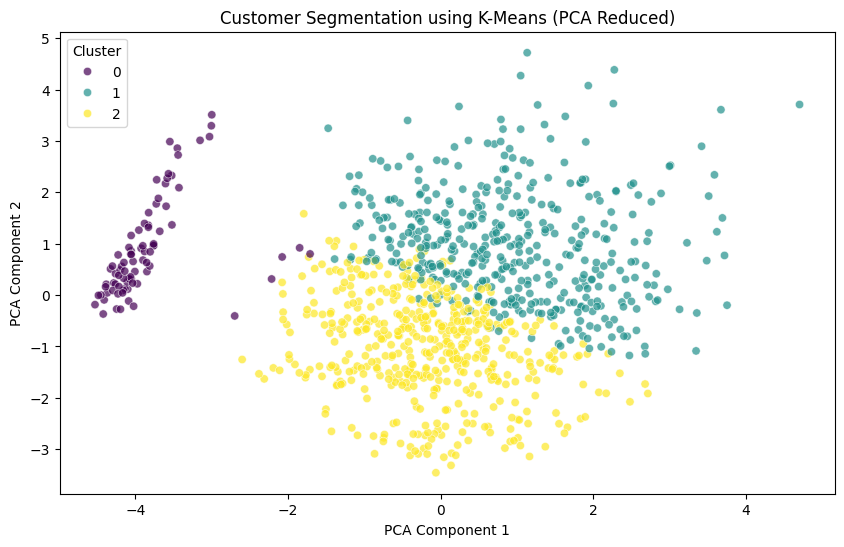

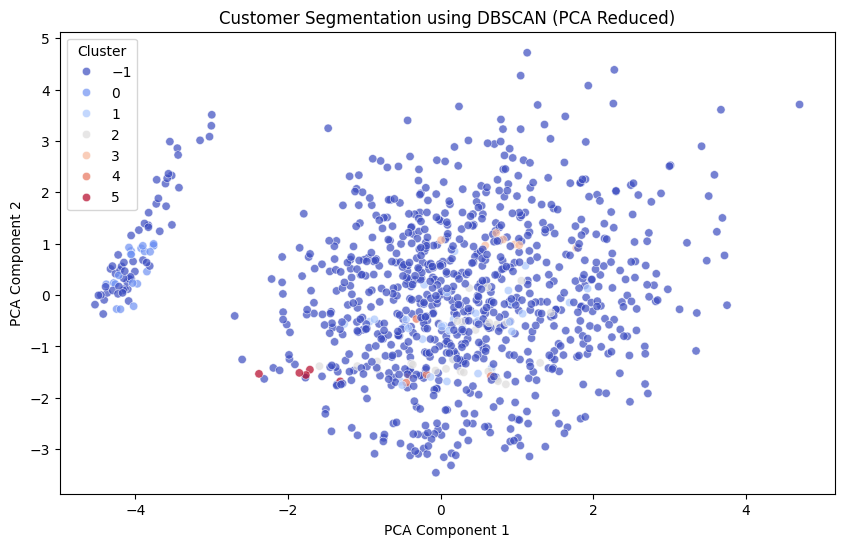

PCA Explained Variance: 0.2228, 0.1688


In [231]:
from sklearn.decomposition import PCA

# Dimensionality Reduction with PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Add PCA components to DataFrame
customers_cluster_df['PCA1'] = X_pca[:, 0]
customers_cluster_df['PCA2'] = X_pca[:, 1]

# Scatter plot for K-Means Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customers_cluster_df['PCA1'], y=customers_cluster_df['PCA2'],
                hue=customers_cluster_df['kmeans_cluster'], palette='viridis', alpha=0.7)
plt.title("Customer Segmentation using K-Means (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Scatter plot for DBSCAN Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customers_cluster_df['PCA1'], y=customers_cluster_df['PCA2'],
                hue=customers_cluster_df['dbscan_cluster'], palette='coolwarm', alpha=0.7)
plt.title("Customer Segmentation using DBSCAN (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Explained Variance Ratio
explained_variance = pca.explained_variance_ratio_
print(f"PCA Explained Variance: {explained_variance[0]:.4f}, {explained_variance[1]:.4f}")


 Key Findings from PCA Visualization (K = 3)

1- K-Means Clusters (PCA Reduced)

Three distinct groups are visible.
Cluster 0 is well-separated, while Clusters 1 and 2 have some overlap.

2- DBSCAN Clusters (PCA Reduced)

DBSCAN fails to create clear clusters, with many points labeled as noise (-1).
The scatterplot looks more chaotic, reinforcing DBSCAN’s poor performance.

Conclusion:

K-Means successfully separates three customer groups.

DBSCAN is ineffective, confirming K-Means is the better approach

# **using k =2**

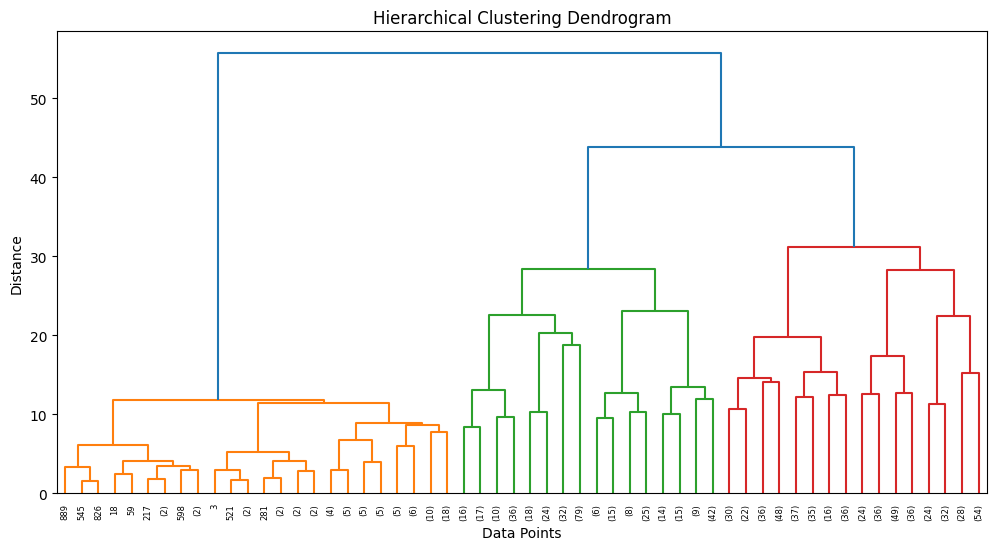

In [234]:
# Step 3: K-Means Clustering
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customers_cluster_df['kmeans_cluster'] = kmeans.fit_predict(X)

# Step 4: DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
customers_cluster_df['dbscan_cluster'] = dbscan.fit_predict(X)

# Step 5: Hierarchical Clustering (Dendrogram)
plt.figure(figsize=(12, 6))
linked = linkage(X, method='ward')
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

### Key Findings from Hierarchical Clustering Dendrogram (K = 2)

Two clear clusters are visible, confirming that K = 2 is a valid segmentation choice.

The left (orange) and right (red) clusters are well-separated, suggesting distinct customer behaviors.

Compared to K = 3, this segmentation groups more customers together, which may reduce precision but improve simplicity.

Conclusion:

K = 2 provides a strong separation but may oversimplify customer differences.

In [235]:
# Step 6: Model Evaluation
kmeans_silhouette = silhouette_score(X, customers_cluster_df['kmeans_cluster'])
kmeans_db_index = davies_bouldin_score(X, customers_cluster_df['kmeans_cluster'])

dbscan_silhouette = silhouette_score(X, customers_cluster_df['dbscan_cluster']) if len(set(customers_cluster_df['dbscan_cluster'])) > 1 else -1
dbscan_db_index = davies_bouldin_score(X, customers_cluster_df['dbscan_cluster']) if len(set(customers_cluster_df['dbscan_cluster'])) > 1 else -1

# Display Clustering Model Evaluation Results
evaluation_results = pd.DataFrame({
    "Model": ["K-Means", "DBSCAN"],
    "Silhouette Score": [kmeans_silhouette, dbscan_silhouette],
    "Davies-Bouldin Index": [kmeans_db_index, dbscan_db_index]
})

print("\nClustering Model Evaluation Results:")
print(evaluation_results)



Clustering Model Evaluation Results:
     Model  Silhouette Score  Davies-Bouldin Index
0  K-Means          0.255605              1.272575
1   DBSCAN         -0.204846              1.918242


### Key Findings from Model Evaluation (K = 2)

1-K-Means Performance

Silhouette Score: 0.2556 → Better separation than K = 3.

Davies-Bouldin Index: 1.27 → Lower than K = 3, indicating more compact clusters.

2- DBSCAN Performance

Negative Silhouette Score (-0.2048) → Poor clustering with high overlap.

Davies-Bouldin Index: 1.91 → Confirms DBSCAN is ineffective.

Conclusion:

K = 2 provides better-separated clusters than K = 3, making it the best choice for distinct segmentation.

DBSCAN is still unsuitable, reinforcing that K-Means is the optimal model.

In [236]:
# Step 7: Segment Analysis

# 1Preferred Branch ID Distribution per Cluster
branch_analysis = customers_cluster_df.groupby("kmeans_cluster")['preferred_branch_id'].agg(lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0])

# Preferred Burn Month per Cluster
burn_month_analysis = customers_cluster_df.groupby("kmeans_cluster")['preferred_burn_month'].agg(lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0])

# Gender Distribution per Cluster
gender_analysis = customers_cluster_df.groupby(["kmeans_cluster", "gender_id"]).size().unstack(fill_value=0)

# City Distribution per Cluster
city_analysis = customers_cluster_df.groupby(["kmeans_cluster", "city_id"]).size().unstack(fill_value=0)

# Combining Segment Analysis for a Summary Table
segment_summary = customers_cluster_df.groupby("kmeans_cluster").agg({
    'total_transactions': ['mean', 'median'],
    'burned_ratio': ['mean'],
    'days_since_last_burn_log': ['mean'],
    'customer_tenure_days': ['mean'],
    'preferred_branch_id': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'preferred_burn_month': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
}).reset_index()

# Displaying Results
print("\nPreferred Branch ID per Cluster:")
print(branch_analysis)

print("\nPreferred Burn Month per Cluster:")
print(burn_month_analysis)

print("\nGender Distribution per Cluster:")
print(gender_analysis)

print("\nCity Distribution per Cluster:")
print(city_analysis)

print("\nSegment Summary Analysis:")
print(segment_summary)


Preferred Branch ID per Cluster:
kmeans_cluster
0   -1.136785
1   -0.778848
Name: preferred_branch_id, dtype: float64

Preferred Burn Month per Cluster:
kmeans_cluster
0   -0.463496
1   -1.739482
Name: preferred_burn_month, dtype: float64

Gender Distribution per Cluster:
gender_id         1    2
kmeans_cluster          
0               460  444
1                44   41

City Distribution per Cluster:
city_id         1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
kmeans_cluster                                                               
0               58  41  54  44  61  42  42  49  42  39  36  47  44  38  53   
1                8   6   4   6   3   6   1   8   3   3   3   3   5   3   4   

city_id         16  17  18  19  20  
kmeans_cluster                      
0               41  48  32  49  44  
1                3   7   1   5   3  

Segment Summary Analysis:
  kmeans_cluster total_transactions           burned_ratio  \
                               mean    media

 ### Key Findings from Segment Analysis (K = 2)
1- Cluster 0 (High Engagement)

More transactions and a higher burn ratio, indicating active coupon users.

Prefers a different branch and burns coupons more frequently.

Larger in size, balanced in gender, and spread across multiple cities.

2- Cluster 1 (Low Engagement)

Fewer transactions and a lower burn ratio, meaning less engaged customers.

Less diverse in city and gender representation.

Longer days since last coupon burn, showing less frequent usage.

Conclusion:

Cluster 0 should receive loyalty-based incentives to maintain engagement.

Cluster 1 needs re-engagement strategies (e.g., targeted promotions, personalized offers).

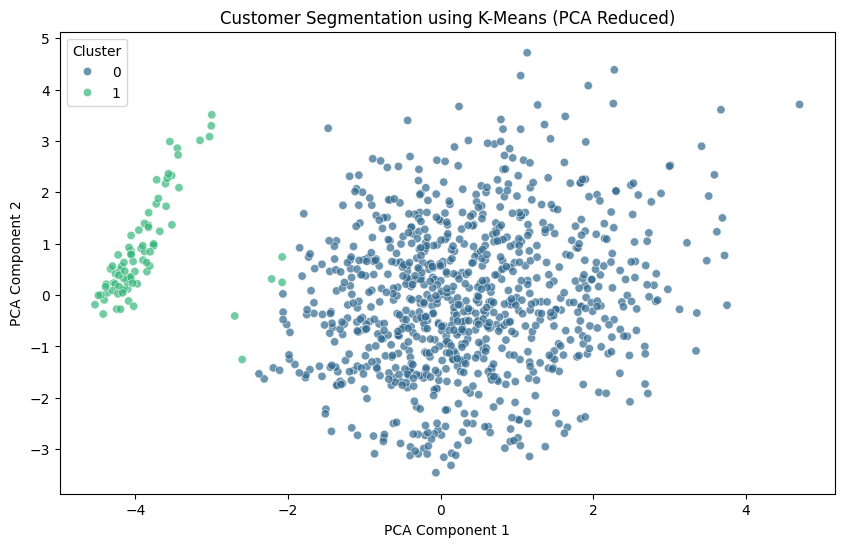

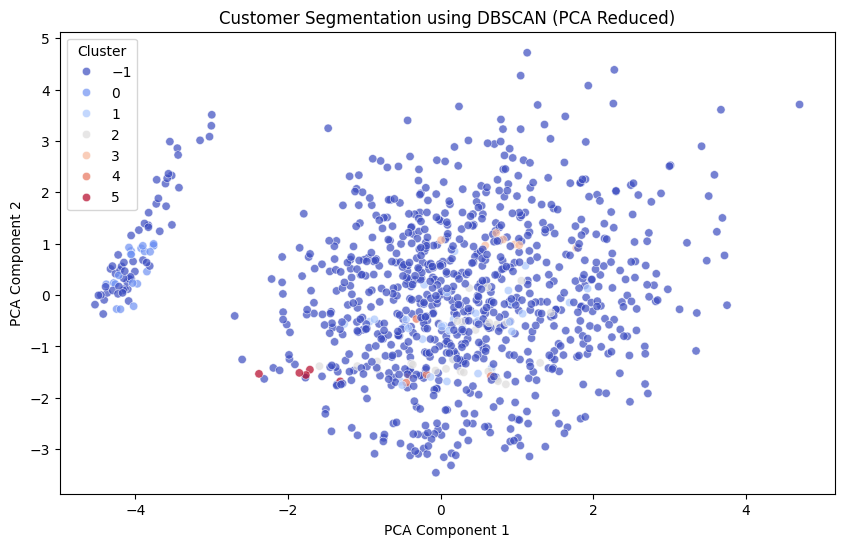

PCA Explained Variance: 0.2228, 0.1688


In [237]:
from sklearn.decomposition import PCA

# Dimensionality Reduction with PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Add PCA components to DataFrame
customers_cluster_df['PCA1'] = X_pca[:, 0]
customers_cluster_df['PCA2'] = X_pca[:, 1]

# Scatter plot for K-Means Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customers_cluster_df['PCA1'], y=customers_cluster_df['PCA2'],
                hue=customers_cluster_df['kmeans_cluster'], palette='viridis', alpha=0.7)
plt.title("Customer Segmentation using K-Means (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Scatter plot for DBSCAN Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customers_cluster_df['PCA1'], y=customers_cluster_df['PCA2'],
                hue=customers_cluster_df['dbscan_cluster'], palette='coolwarm', alpha=0.7)
plt.title("Customer Segmentation using DBSCAN (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Explained Variance Ratio
explained_variance = pca.explained_variance_ratio_
print(f"PCA Explained Variance: {explained_variance[0]:.4f}, {explained_variance[1]:.4f}")


Key Findings from PCA Visualization (K = 2)

1- K-Means Clusters (PCA Reduced)

Two well-separated groups, confirming strong segmentation.

Cluster 0 is much larger, while Cluster 1 is more compact and distinct.

2- DBSCAN Clusters (PCA Reduced)

DBSCAN still fails to form clear clusters, with many noise points (-1).

The distribution remains scattered and unclear, reinforcing DBSCAN’s poor performance.

Conclusion:

K = 2 forms clearly distinct customer groups, making it the stronger choice over K = 3.

DBSCAN is unreliable, and K-Means remains the optimal method.

# **Final Conclusion:**

K = 2 is the best clustering choice for this dataset because it provides:

Better separation between clusters (higher silhouette score).

More compact and distinct customer groups (lower DB index).

A simpler, business-friendly segmentation (clearer PCA visualization).

K = 3 still provides useful insights for a more granular segmentation, but clusters overlap more.

Business Recommendation Using K = 2:

Cluster 0 (high engagement): Frequent coupon users, target with loyalty rewards.

Cluster 1 (low engagement): Inactive customers, target with re-engagement offers.
